214 [0.16641588 0.74534595]
267 [-0.98206342  0.1657408 ]
209 [0.34155916 0.6448127 ]
284 [-0.36982975 -0.63359654]
177 [-0.06620447  0.30770133]
290 [-0.10566516  0.5453556 ]
11 [0.51071228 0.42261925]
34 [-0.22454294 -0.75510456]
81 [-0.50343085  0.8918323 ]
38 [ 0.08048635 -0.16564073]
43 [ 0.41335722 -0.00957854]
152 [ 0.61771028 -0.32429929]
244 [ 0.34169887 -0.60406228]
165 [-0.90598659  0.51489239]
279 [ 0.20974419 -0.96416858]
46 [-0.9090057   0.44901494]
61 [-0.97702167  0.61131438]
47 [ 0.53571265 -0.32404554]
89 [-0.00267318 -0.98404953]
158 [0.81654975 0.95340241]
163 [ 0.58714846 -0.14127687]
168 [-0.21705724 -0.33533252]
226 [ 0.21449173 -0.5301467 ]
263 [ 0.23338033 -0.04101286]
125 [-0.64072527  0.88828635]
173 [-0.19609655 -0.44758141]
220 [ 0.32353486 -0.48417854]
101 [-0.3335914   0.48327898]
258 [ 0.32672349 -0.0274491 ]
36 [ 0.47505749 -0.60407064]
247 [-0.95591707 -0.75675013]
7 [ 0.30166778 -0.95559505]
216 [0.28506471 0.33847541]
222 [-0.20811988 -0.59707324]
16

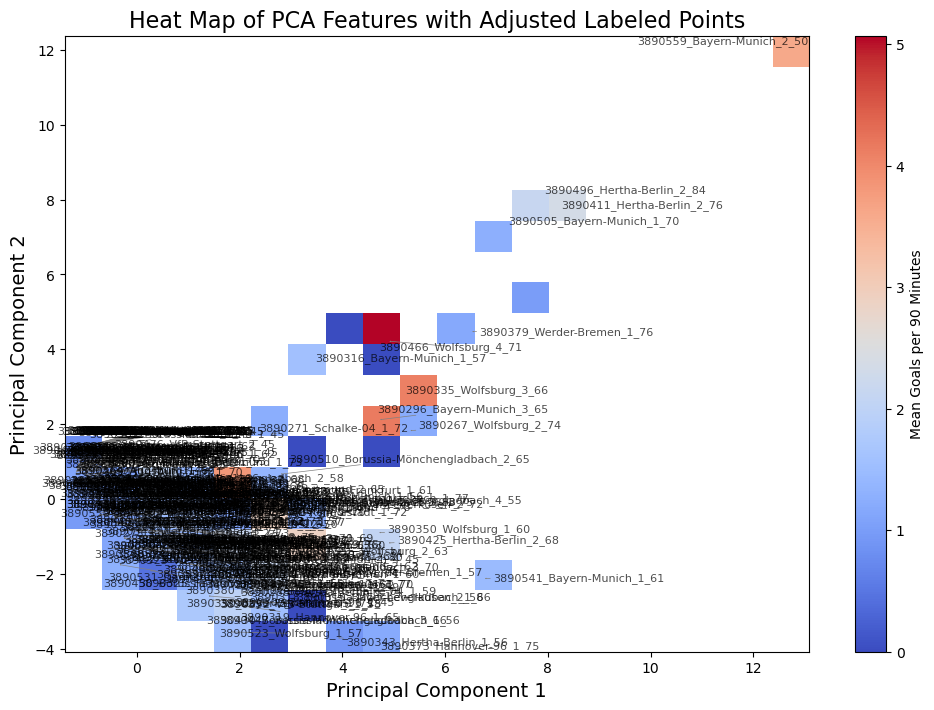

In [1]:
import os
import re
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ripser import ripser
from scipy.stats import binned_statistic_2d
from adjustText import adjust_text

# Function to construct adjacency matrix
def construct_adjacency_matrix(game_data):
    G = nx.Graph()
    max_count = max(pass_info["count"] for player in game_data for pass_info in player["passes"])

    for player in game_data:
        G.add_node(player["name"], pos=(player["x"], player["y"]))

    for player in game_data:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            edge_weight = count / max_count
            G.add_edge(player1, player2, weight=edge_weight)

    return G

# Function to extract persistence diagram features
def extract_features(persistence_diagrams):
    features = []
    max_len = 0

    for diagram in persistence_diagrams:
        if diagram and len(diagram) > 0:
            diagram = np.array(diagram[0])
            lifespan = diagram[:, 1] - diagram[:, 0]
            features.append(lifespan)
            max_len = max(max_len, len(lifespan))
        else:
            features.append(np.zeros(1))

    padded_features = []
    for feature in features:
        if len(feature) < max_len:
            padded_features.append(np.pad(feature, (0, max_len - len(feature)), mode="constant"))
        else:
            padded_features.append(feature)

    return np.array(padded_features)

# Function to extract goals and time from file names
def extract_goals_and_time(file_name):
    match = re.search(r"_(\d+)_(\d+)\.json", file_name)
    if match:
        goals = int(match.group(1))
        time = int(match.group(2))
        return goals / time * 90  # Normalize to 90 minutes
    return 0

# Function to clean and validate JSON files
def clean_json(file_path):
    with open(file_path, "r") as f:
        raw_data = f.read()
    try:
        return json.loads(raw_data)
    except json.JSONDecodeError:
        # Attempt to fix common JSON issues
        fixed_data = raw_data.replace("\r", "").replace("\n", "").replace("\t", "").replace("\\", "")
        fixed_data = re.sub(r",\s*}", "}", fixed_data)  # Remove trailing commas before }
        fixed_data = re.sub(r",\s*\]", "]", fixed_data)  # Remove trailing commas before ]
        try:
            return json.loads(fixed_data)
        except json.JSONDecodeError as e:
            print(f"Failed to clean {file_path}: {e}")
            return None

# Define folder paths
folder_path = '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/'

# Get a list of all files in the folder
file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.json')]

# Load all files
data = []
invalid_files = []

for file_path in file_paths:
    cleaned_data = clean_json(file_path)
    if cleaned_data:
        data.append(cleaned_data)
    else:
        invalid_files.append(file_path)

# Log invalid files
if invalid_files:
    print(f"Skipped {len(invalid_files)} invalid files.")
    for invalid_file in invalid_files:
        print(invalid_file)

# Process valid data
persistence_diagrams = []
valid_file_paths = []

for file_path, match_data in zip(file_paths, data):
    try:
        G = construct_adjacency_matrix(match_data)
        adj_matrix = nx.to_numpy_array(G)
        diagrams = ripser(adj_matrix, distance_matrix=True)["dgms"]
        persistence_diagrams.append(diagrams)
        valid_file_paths.append(file_path)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Extract features from persistence diagrams
if persistence_diagrams:
    features = extract_features(persistence_diagrams)

    # Handle NaN or infinity values
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)

    # Extract goals per 90 minutes
    goals_per_90 = [extract_goals_and_time(os.path.basename(file_path)) for file_path in valid_file_paths]

    # Generate labels for each point (e.g., filenames as labels)
    labels = [os.path.basename(file_path).replace(".json", "") for file_path in valid_file_paths]

    # Function to plot heatmap with adjusted labels
    def plot_heatmap_with_adjusted_labels(features_pca, goals_per_90, labels, bins=50):
        # Compute binned statistics
        stat, x_edges, y_edges, binnumber = binned_statistic_2d(
            features_pca[:, 0], features_pca[:, 1], goals_per_90, statistic="mean", bins=bins
        )

        # Plot the heatmap
        plt.figure(figsize=(12, 8))
        plt.imshow(
            stat.T,  # Transpose to match x/y orientation
            origin="lower",
            extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
            aspect="auto",
            cmap="coolwarm",
        )
        cb = plt.colorbar(label="Mean Goals per 90 Minutes")
        plt.title("Heat Map of PCA Features with Adjusted Labeled Points", fontsize=16)
        plt.xlabel("Principal Component 1", fontsize=14)
        plt.ylabel("Principal Component 2", fontsize=14)

        # Overlay selected labels
        texts = []
        density_threshold = 0.2  # Adjust threshold for fewer/more labels
        for i, (x, y) in enumerate(features_pca):
            # Show labels for sparse areas or high-impact points
            density = binnumber[i] / bins
            if density < density_threshold or goals_per_90[i] > np.mean(goals_per_90):
                texts.append(plt.text(x, y, labels[i], fontsize=8, color="black", alpha=0.7))

        # Automatically adjust text positions to avoid overlaps
        adjust_text(
            texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5), only_move={'points': 'y', 'texts': 'xy'}
        )

        plt.grid(False)
        plt.show()

    # Call the function to plot
    plot_heatmap_with_adjusted_labels(features_pca, goals_per_90, labels, bins=20)

else:
    print("No valid persistence diagrams were computed.")
